In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import torchmetrics
from collections import Counter

In [2]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), # Resize all images to a uniform size (e.g., 64x64 pixels)
    transforms.ToTensor(), # Convert PIL Image to PyTorch tensor (0-255 to 0.0-1.0)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize pixel values
])

train_data_dir = 'dataset/Human Faces Dataset' 
full_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.7, 0.3])


print(dict(Counter(train_dataset.dataset.targets)))

print(dict(Counter(test_dataset.dataset.targets)))
print(dict(Counter(full_dataset.targets)))


{0: 5000, 1: 4630}
{0: 5000, 1: 4630}
{0: 5000, 1: 4630}


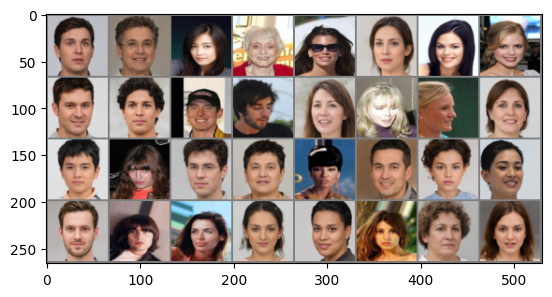

In [5]:
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading 
)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [6]:
# Get the targets for the subset
subset_targets = [full_dataset.targets[i] for i in test_dataset.indices]

# Calculate the class distribution
class_distribution = Counter(subset_targets)
class_distribution

Counter({0: 1544, 1: 1345})

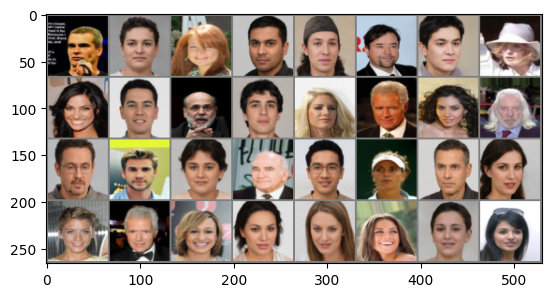

In [7]:
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading 
)

# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.88235295].


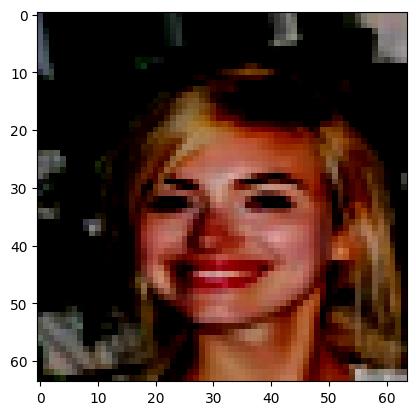

torch.Size([3, 64, 64])

In [8]:
#Sanity check (set shuffle=False in loader so order in file explorer is perserved)
index=0
npimg=train_loader.dataset[index][0].numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
train_loader.dataset[index][1]

img, label=train_loader.dataset[index]
img.size()


<h2> FEATURE EXTRACTION FUNCTION </h2>

In [9]:

# function to extract features 
def extract_features(data_loader):
    #iterates through DataLoader and flattens image tensors
    all_features = []
    all_labels = []

    for images, labels in data_loader:
        # flatten the image data: C * H * W
        # resulting shape: (Batch, Features)
        flattened_images = images.reshape(images.shape[0], -1)

        # convert to numpy and append
        all_features.append(flattened_images.numpy())
        all_labels.append(labels.numpy())

    # concatenates all batches into single numpy arrays
    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    
    return X, y

<h2> LP </h2>

In [10]:
full_loader = DataLoader(full_dataset, batch_size=64, shuffle=False)
print("Processing all image data...")
X_full, y_true_full = extract_features(full_loader)
print(f"Feature Matrix Shape (X_full): {X_full.shape}")

train_indices = train_dataset.indices
all_indices = np.arange(len(full_dataset))


y_lp = np.full(len(full_dataset), -1)
y_lp[train_indices] = y_true_full[train_indices] # now y_lp has true labels (0-9) for training set samples, -1 for test set samples
# X_full contains the features for ALL samples
# y_lp contains labels for labeled samples and -1 for unlabeled samples

Processing all image data...
Feature Matrix Shape (X_full): (9630, 12288)


In [11]:
from sklearn.semi_supervised import LabelPropagation


print("\nStarting Label Propagation...")
label_propagator = LabelPropagation(kernel='knn', n_neighbors=7)
label_propagator.fit(X_full, y_lp)
print("Label Propagation complete.")


# prediction is the output of fit
test_indices = test_dataset.indices
y_pred_lp = label_propagator.transduction_[test_indices]
y_true_test = y_true_full[test_indices]

from sklearn.metrics import classification_report
print("Label Propagation Classification Report")
print(classification_report(y_true_test, y_pred_lp))


Starting Label Propagation...
Label Propagation complete.
Label Propagation Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1544
           1       0.86      1.00      0.92      1345

    accuracy                           0.92      2889
   macro avg       0.93      0.93      0.92      2889
weighted avg       0.93      0.92      0.92      2889



<h2> GB </h2>

In [12]:
print("Processing Training Data...")
X_train, y_train = extract_features(train_loader)

print("Processing Testing Data...")
X_test, y_test = extract_features(test_loader)

print(f"\nFinal X_train shape for GB: {X_train.shape}")
print(f"Final X_test shape for GB: {X_test.shape}")

Processing Training Data...
Processing Testing Data...

Final X_train shape for GB: (6741, 12288)
Final X_test shape for GB: (2889, 12288)


In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

gb.fit(X_train,y_train)

y_predictions=gb.predict(X_test)

print("GRADIENT BOOSTING")
print(classification_report(y_test,y_predictions))




GRADIENT BOOSTING
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1544
           1       1.00      1.00      1.00      1345

    accuracy                           1.00      2889
   macro avg       1.00      1.00      1.00      2889
weighted avg       1.00      1.00      1.00      2889

